Shape: (303, 14)
Columns: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


Numeric features: ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
Categorical features: ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
Total features after preprocessing: 28


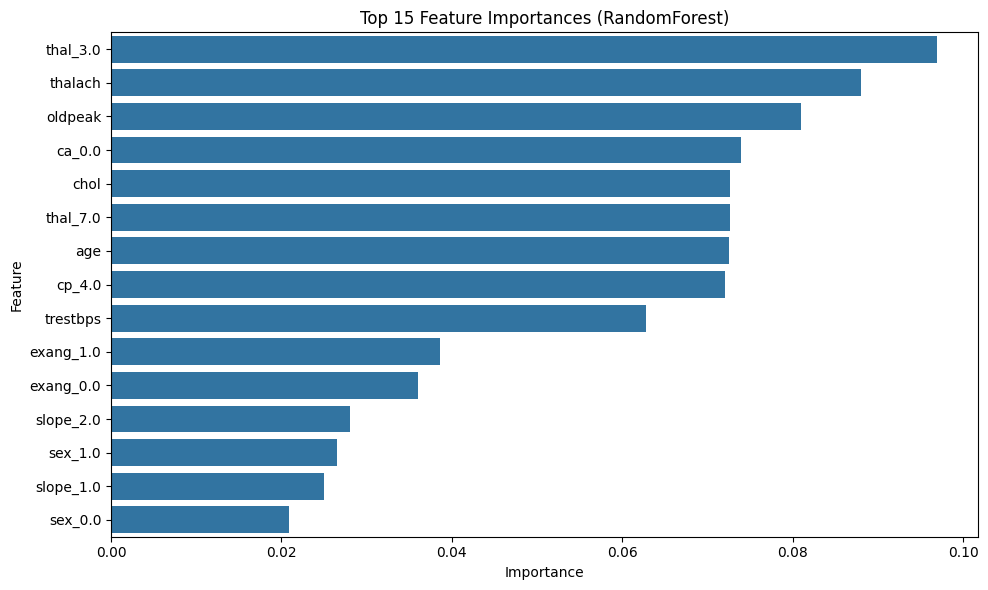

Feature importance saved to ../results/feature_importance.csv

Top 10 features selected by RFE:
- oldpeak
- sex_0.0
- cp_1.0
- cp_3.0
- cp_4.0
- exang_1.0
- slope_2.0
- ca_0.0
- ca_2.0
- thal_7.0

Selected features list saved to ../results/selected_features.txt


In [6]:
# ============================================================
# 03_feature_selection.ipynb
# Feature importance and selection on Heart Disease dataset
# ============================================================

# ---- Cell 1: Imports ----
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# ---- Cell 2: Load cleaned dataset ----
df = pd.read_csv('../results/cleaned_heart.csv')
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
display(df.head())

# ---- Cell 3: Separate features and target ----
target_col = 'num'
X = df.drop(columns=[target_col])
y = df[target_col]

# ---- Cell 4: Explicitly set numeric and categorical features ----
numeric_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

# ---- Cell 5: Preprocessing pipeline ----
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# ---- Cell 6: Train/test split ----
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ---- Cell 7: RandomForest feature importance ----
rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=200, random_state=42))
])
rf.fit(X_train, y_train)

# Get feature names after preprocessing
all_feature_names = rf.named_steps['preprocessor'].get_feature_names_out()
all_feature_names = [name.split("__")[-1] for name in all_feature_names]
print("Total features after preprocessing:", len(all_feature_names))

# Get importances
importances = rf.named_steps['classifier'].feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot top 15 features
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15))
plt.title('Top 15 Feature Importances (RandomForest)')
plt.tight_layout()
plt.show()

# Save feature importance table
feature_importance_df.to_csv('../results/feature_importance.csv', index=False)
print("Feature importance saved to ../results/feature_importance.csv")

# ---- Cell 8: Recursive Feature Elimination (RFE) ----
log_reg = LogisticRegression(max_iter=1000, solver='liblinear')

# Apply preprocessing to whole dataset
X_preprocessed = preprocessor.fit_transform(X, y)

# RFE on numeric + encoded features
rfe = RFE(log_reg, n_features_to_select=10)
rfe.fit(X_preprocessed, y)

selected_features_mask = rfe.support_
selected_features = [all_feature_names[i] for i in range(len(all_feature_names)) if selected_features_mask[i]]

print("\nTop 10 features selected by RFE:")
for f in selected_features:
    print("-", f)

# Save selected features list
with open('../results/selected_features.txt', 'w') as f:
    for feat in selected_features:
        f.write(f"{feat}\n")

print("\nSelected features list saved to ../results/selected_features.txt")
